# Labsheet

In [21]:
import re  # For preprocessing
import pandas as pd  # For data handling
import spacy  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

In [4]:
df = pd.read_csv('/content/simpsons_dataset.csv')
df.shape

(158314, 2)

In [5]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [6]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [7]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [12]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [15]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 5.95 mins


In [16]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85955, 1)

In [23]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [25]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29694

In [26]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

In [27]:
import multiprocessing
from gensim.models import Word2Vec

In [41]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [31]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [32]:
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60,
2)))

Time to build vocab: 0.01 mins


In [33]:
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count,
epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) /
60, 2)))


Time to train the model: 1.13 mins


In [34]:
w2v_model.init_sims(replace=True)


<ipython-input-34-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [35]:
w2v_model.wv.most_similar(positive=["homer"])
# TODO: Check the output for "homer_simpson", "marge", "bart"


[('sweetheart', 0.7089717984199524),
 ('marge', 0.6976544857025146),
 ('humiliate', 0.6959439516067505),
 ('depressed', 0.6958469152450562),
 ('gee', 0.6857178211212158),
 ('snuggle', 0.6756035089492798),
 ('hammock', 0.6676444411277771),
 ('embarrassing', 0.6632099151611328),
 ('badly', 0.6603363752365112),
 ('terrific', 0.660012423992157)]

In [40]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.816462516784668),
 ('substitute', 0.7469272613525391),
 ('hearing', 0.7419347763061523),
 ('mom', 0.7076283097267151),
 ('convince', 0.705653727054596),
 ('pay_attention', 0.6990543603897095),
 ('homework', 0.6973274946212769),
 ('embarrassing', 0.6957261562347412),
 ('jealous', 0.6952784061431885),
 ('dr_hibbert', 0.6891682147979736)]

In [36]:
w2v_model.wv.similarity('maggie', 'baby')
# TODO: Construct a NxN similarity matrix for the N values: 'maggie',
'baby', 'bart', 'nelson', 'tavern'


('baby', 'bart', 'nelson', 'tavern')

In [39]:
w2v_model.wv.similarity('maggie', 'baby')

0.76742184

In [37]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [38]:
w2v_model.wv.most_similar(positive=["woman", "homer"],
negative=["marge"], topn=3)

[('admire', 0.5787416696548462),
 ('married', 0.5592732429504395),
 ('juliet', 0.5509849786758423)]

# Exercise

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from collections import defaultdict

In [43]:
class Model():

    def __init__(self, data, settings):

        self.settings = settings
        self.data = data
        self.X = self.data.X
        self.fun = np.vectorize(self.f)
        self.plot_initialise()
        self.J_list = []

    def train(self):

        self.prepare()
        i_list = []
        # Iterating through the entire dataset epoch number of times
        for i in range(0, self.settings.epoch):

            delta = self.fun(self.X) * (self.U @ self.V - np.log(self.X))
            U_grad = delta @ self.V.T
            V_grad = self.U.T @ delta

            U_grad[:, self.settings.d+1] = 0
            V_grad[self.settings.d+1, :] = 0

            # Updating U and V
            self.U = self.U - self.settings.a * U_grad
            self.V = self.V - self.settings.a * V_grad

            # Plotting Loss
            self.update_loss()
            i_list.append(i)
        self.plot(i_list)

    def prepare(self):

        self.U = np.random.uniform(-1, 1, (self.data.T, self.settings.d + 2))
        self.V = np.random.uniform(-1, 1, (self.settings.d + 2, self.data.T))

        for i in range(0, self.data.T):
            self.U[self.settings.d + 1, i] = 1
            self.V[i, self.settings.d + 1] = 1

    def f(self, x):

        if x > self.settings.xmax:
            return 1

        else:
            y = (x/self.settings.xmax)**self.settings.f_a
            return y

    def update_loss(self):

        J = self.fun(self.X) * ((self.U @ self.V - np.log(self.X))**2)
        self.J = J.sum() / 2
        self.J_list.append(self.J)

    def plot(self, i_list):

        # s - Marker size
        plt.scatter(i_list, self.J_list, color = 'red', s = 3)
        plt.show(block = False)
        plt.pause(0.001)

    def plot_initialise(self):

        style.use('dark_background')
        plt.figure()
        plt.xlabel('Number of iterations')
        plt.ylabel('Loss')

    def predict(self, word):

        index = self.data.word_index[word]
        w = self.U[index, :].T + self.V[:, index]
        return w[1:-1] / 2

In [44]:
class Settings():

    def __init__(self):

        # Hyper Parameter
        self.m = 3
        self.d = 10
        self.a = 0.01
        self.epoch = 100
        self.xmax = 1
        self.f_a = 0.75

In [45]:
class Data():

    def __init__(self, settings):

        self.m = settings.m
        self.make_corpus()
        self.co_occurrence_matrix()

    def make_corpus(self):

        text = "i love doing this project it is the thing which i enjoy the most"
        corpus = [[word.lower() for word in text.split()]]
        self.corpus = corpus

    def preparation(self):

        """ Making the frequency matrix"""
        self.word_freq = defaultdict(int)

        for sentence in self.corpus:
            for word in sentence:
                self.word_freq[word] += 1

        # self.words decide the index of all the words
        self.words = list(self.word_freq.keys())
        self.T = len(self.words)

        # word_index will give index for a given word and vice versa for index_word
        self.word_index = dict([[word, i] for i, word in enumerate(self.words)])
        self.index_word = dict([[i, word] for i, word in enumerate(self.words)])

    def co_occurrence_matrix(self):

        self.preparation()

        # In X each word have a particular row and column according to their index.
        # Xij - tabulate number of times word j appear in the context of word i
        self.X = np.zeros([self.T, self.T])
        self.X += 0.0001

        for sentence in self.corpus:

            sen_len = len(sentence)

            for i, c_word in enumerate(sentence):
                # target is the center word index
                # context is the context word index
                target = self.word_index[c_word]

                for j in range(i-self.m, i+self.m+1):

                    if j != i and 0 <= j and j < sen_len:

                        context_word = sentence[j]
                        context = self.word_index[context_word]
                        self.X[target, context] += 1 / abs(i-j)

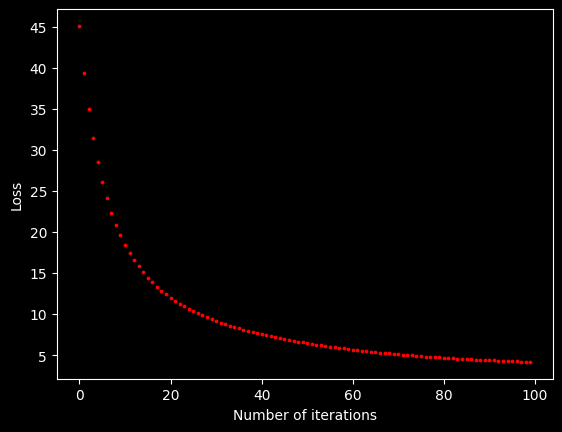

In [46]:
""" Conventions

   m - Window size
   d - Dimension of vectors
   a - Learning rate
   U - Matrix for hidden layer calculation
   V - Matrix for output calculation
   X - Co-occurrence matrix
   T - Total number of unique words
   J - Loss
   u - target vector
   v - context vector

"""

settings = Settings()
data = Data(settings)
model = Model(data, settings)
model.train()

In [47]:
word = input('Enter the word whose vector you wanna see.\n')
print(model.predict(word))

Enter the word whose vector you wanna see.
thing
[ 0.34752367  0.0585213  -0.64194196 -0.74397698 -0.33905294 -0.68235125
  0.75592087  0.09306735 -0.2719898  -0.84537667]
